## Masked Properly?
### Group 1

#### Image Classification using Tensor Flow

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import os
import struct
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf

print(f'TensorFlow version= {tf.__version__}')
print(f"CUDA available= {tf.test.gpu_device_name()}")

# # Check CUDA TensorFlow
tf.test.is_built_with_cuda()

TensorFlow version= 2.8.0
CUDA available= 


True

In [2]:
#Parameters for tuning

NUM_EPOCHS = 3
# number of samples
# Note if samples is > than actual number, then actual number is used
num_CMFD_samples = 4000
num_RMFD_samples = 750
num_google_samples = 130

## Preprocessing

1) Make sure the size of the images meet the input layer size requirements <br>
    a. Completed above, downsampled to 128 x 128 using opencv
2) Make sure images are rgb bgr like opencv reads them <br>
    Update On this, moved to gray scale due to memory issues <br>
3) Scale from 0 to 1 <br>

In [41]:
def get_images_from_folder(IMGSIZE, max_images, path, label):
    X, Y = [], []
    suffixes = ('.jpg', '.png', '.webp', '.jpeg')
    count = 0
    break_flag = False
    print(f'Path: {path}')
    for subdir, dirs, files in os.walk(path):
        for f in files:
            if f.endswith(suffixes):
                X += [cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(subdir,f)), cv2.COLOR_BGR2RGB), IMGSIZE)]
#                 X += [cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(subdir,f)), cv2.COLOR_BGR2GRAY), IMGSIZE)]
                Y += [label]
                count+= 1
                if (count+1) % 500 == 1:
                    print(f'read {count} images')
                if count == max_images:
                    break_flag = True
                    break
        if break_flag == True:
            break
    return np.array(X),np.array(Y)

In [4]:
# Downsample images to 128x128
IMGSIZE = (128, 128)
X, Y = [],[]
for i in range(6):
    X.append([])
    Y.append([])
# Get the synthetic data first
X_temp, Y_temp = get_images_from_folder(IMGSIZE, 2*num_CMFD_samples, './CMFD/CMFD', [1,0])
ind = np.arange(len(X_temp))
np.random.shuffle(ind)
X[0] = X_temp[ind[0:num_CMFD_samples]]
X_validate = X_temp[ind[num_CMFD_samples:-1]]
Y[0] = Y_temp[ind[0:num_CMFD_samples]]
Y_validate = Y_temp[ind[num_CMFD_samples:-1]]
X_temp, Y_temp = get_images_from_folder(IMGSIZE, 2*num_CMFD_samples, './IMFD/IMFD', [0,1])
ind = np.arange(len(X_temp))
np.random.shuffle(ind)
X[1] = X_temp[ind[0:num_CMFD_samples]]
Y[1] = Y_temp[ind[0:num_CMFD_samples]]
X_validate = np.concatenate((X_validate, X_temp[ind[num_CMFD_samples:-1]]))
Y_validate = np.concatenate((Y_validate, Y_temp[ind[num_CMFD_samples:-1]]))

# Data from the Real Masked Face Dataset
X_temp, Y_temp = get_images_from_folder(IMGSIZE, num_RMFD_samples, './RMFD/Masked_All', [1,0])
X[2] = X_temp
Y[2] = Y_temp
X_temp, Y_temp = get_images_from_folder(IMGSIZE, num_RMFD_samples, './RMFD/Improper_All', [0,1])
X[3] = X_temp
Y[3] = Y_temp

X_temp, Y_temp = get_images_from_folder(IMGSIZE, num_google_samples, './CMFD_google', [1,0])
X[4] = X_temp
Y[4] = Y_temp
X_temp, Y_temp = get_images_from_folder(IMGSIZE, num_google_samples, './IMFD_google', [0,1])
X[5] = X_temp
Y[5] = Y_temp
print(f'Synth image length: {len(X[0]) + len(X[1])} label length: {len(Y[0]) + len(Y[1])}')
print(f'RMFD image length: {len(X[2]) + len(X[3])} label length: {len(Y[2]) + len(Y[3])}')
print(f'Team image length: {len(X[4]) + len(X[5])} label length: {len(Y[4]) + len(Y[5])}')

Path: ./CMFD/CMFD
read 500 images
read 1000 images
read 1500 images
read 2000 images
read 2500 images
read 3000 images
read 3500 images
read 4000 images
read 4500 images
read 5000 images
read 5500 images
read 6000 images
read 6500 images
read 7000 images
read 7500 images
read 8000 images
Path: ./IMFD/IMFD
read 500 images
read 1000 images
read 1500 images
read 2000 images
read 2500 images
read 3000 images
read 3500 images
read 4000 images
read 4500 images
read 5000 images
read 5500 images
read 6000 images
read 6500 images
read 7000 images
read 7500 images
read 8000 images
Path: ./RMFD/Masked_All
read 500 images
Path: ./RMFD/Improper_All
read 500 images
Path: ./CMFD_google
Path: ./IMFD_google
Synth image length: 8000 label length: 8000
RMFD image length: 1500 label length: 1500
Team image length: 260 label length: 260


In [5]:
# for i,x in enumerate(X):
#     X[i] = x.reshape(x.shape[0],x.shape[1],x.shape[2],1)

### Randomly plot 8 samples from each of the databases

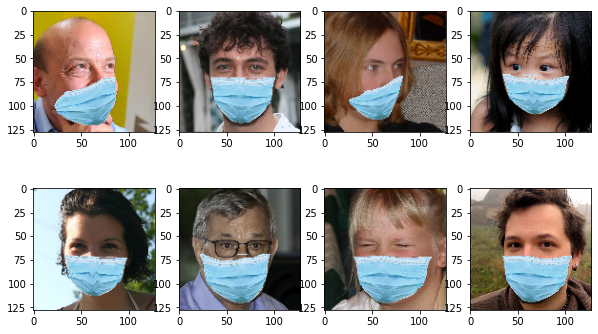

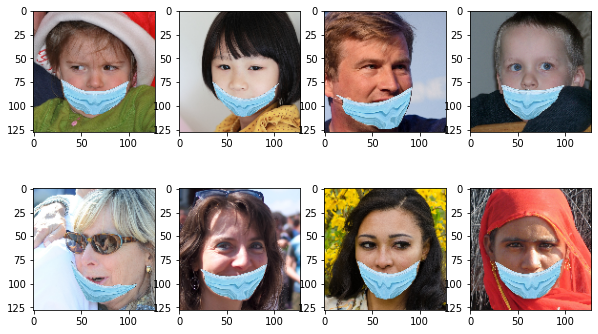

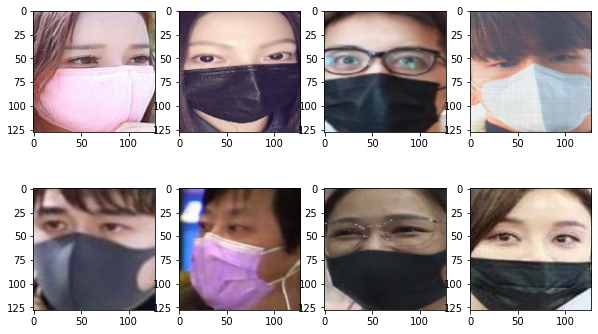

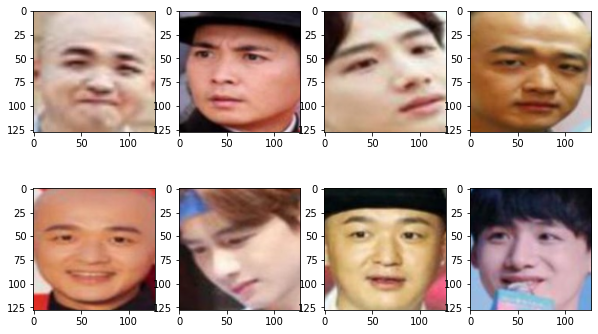

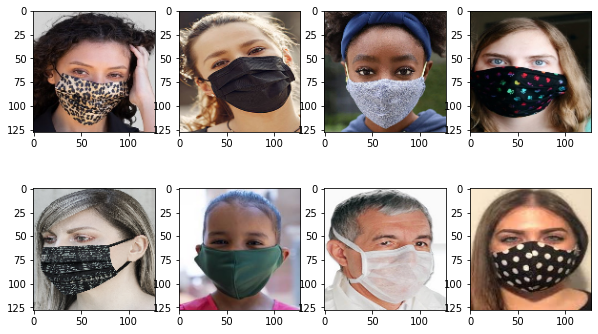

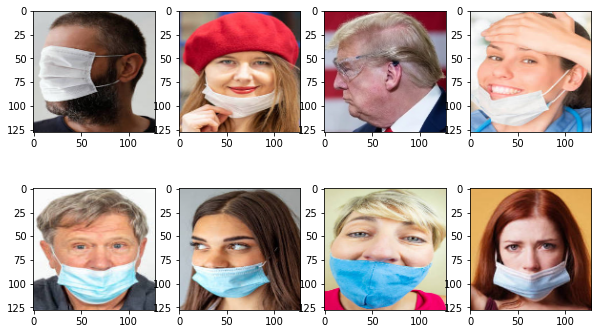

In [6]:
from random import randrange
# plot 25 random photos
for x in X:
    random_indx = []
    for i in range(8):
        random_indx.append(randrange(len(x)))

    fig, ax = plt.subplots(2,4,figsize=(10,6))
    count = 0
    for r in range(2):
        for c in range(4):
            ax[r][c].imshow(x[random_indx[count]],cmap='gray')
            count = count + 1
    plt.show()

### Create Train and Test samples 10 fold cross validation

Need to create a home-grown 10 fold to ensure each set has data from each of the databases

In [7]:
def k_fold_data_creation(X, n_folds):
    test_indices, train_indices = [],[]
    for j in range(n_folds):
        test_indices.append([])
        train_indices.append([])
        for i in range(len(X)):
            test_indices[j].append([])
            train_indices[j].append([])
    for t, x in enumerate(X):
        indices = np.arange(len(x))
        np.random.shuffle(indices)
        for i in range(n_folds):
            first_indx = int(i*len(x)/(n_folds))
            last_indx = int((i+1)*len(x)/(n_folds))
            test_indices[i][t] = indices[first_indx:last_indx]
            train_indices[i][t] = np.concatenate((indices[0:first_indx],indices[last_indx:-1]))
    return test_indices, train_indices
    

Create the folds for each of the k test iterations

In [8]:
test_ind, train_ind = k_fold_data_creation(X, 10)

### Create CNN

In [9]:
# Our full CNN neural network
def create_model(k_s, filter_1, filter_2, layer_1, layer_2):
    cnn1 = tf.keras.Sequential()

    cnn1.add(tf.keras.layers.Conv2D(filters=filter_1, kernel_size=k_s,
        data_format='channels_last',
        name='conv_1', activation='relu'))

    cnn1.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_1'))

    cnn1.add(tf.keras.layers.Conv2D(filters=filter_2, kernel_size=k_s,
        name='conv_2', activation='relu'))

    cnn1.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))
    
#     cnn1.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
#         name='conv_3', activation='relu'))

#     cnn1.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_3'))

    cnn1.add(tf.keras.layers.Flatten())

    cnn1.add(tf.keras.layers.Dense(units=layer_1, name='fc_1', activation='relu'))
    
    cnn1.add(tf.keras.layers.Dense(units=layer_2, name='fc_2', activation='relu'))

    cnn1.add(tf.keras.layers.Dense(units=2, name='fc_3', activation='softmax'))
    
        # Set a seed for repeatibility
#     tf.random.set_seed(42)

    # Build the model
    cnn1.build(input_shape=(None, 128, 128, 3)) # None, 128, 128, 3 for rgb
#     cnn1.build(input_shape=(None, 128, 128, 1)) # None, 128 X 128, 1 gray

#     cnn1.summary()

    # Compile the model with the optimizer, loss function and metric
    cnn1.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy'])

    return cnn1

In [10]:
def ten_fold_test(k_s, filter_1, filter_2, layer_1, layer_2):
    tp, fp, tn, fn, acc, sens, spec = [], [], [], [], [], [], []
    for i in range(3):
        tp.append([])
        fp.append([])
        tn.append([])
        fn.append([])
        acc.append([])
        sens.append([])
        spec.append([])
    # k_fold x database size
    for te_i, tr_i in zip(test_ind, train_ind):
        # create empty Train Index
        for i, train in enumerate(tr_i):
            if i == 0:
                X_train = X[i][train]
                Y_train = Y[i][train]
            else:
                X_train = np.concatenate((X_train, X[i][train]))
                Y_train = np.concatenate((Y_train, Y[i][train]))
        X_train = X_train/255
#         print(f'{X_train.shape} {Y_train.shape}')
        cnn1 = create_model(k_s, filter_1, filter_2, layer_1, layer_2)
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
        history = cnn1.fit(X_train, Y_train,
            epochs=NUM_EPOCHS,callbacks=[callback], verbose=1,
            shuffle=True)
        for i, test in enumerate(te_i):
            y_pred = cnn1.predict(X[i][test])
            y_pred = np.argmax(y_pred, axis=-1)
            y_check = np.argmax(Y[i][test], axis=-1) 
            m = int(i/2)
            if (i+2)%2 == 0: # even
                tp[m].append(sum(y_pred==y_check))
                fn[m].append(sum(y_pred!=y_check))
                sens[m].append(tp[m][-1]/(tp[m][-1]+fn[m][-1]))
            else:
                tn[m].append(sum(y_pred==y_check))
                fp[m].append(sum(y_pred!=y_check))
                spec[m].append(tn[m][-1]/(tn[m][-1]+fp[m][-1]))
                acc[m].append((tp[m][-1]+tn[m][-1])/(tp[m][-1]+tn[m][-1]+fn[m][-1]+fp[m][-1]))
            print(f'Size: {len(y_pred)} Accuracy {i}= {sum(y_pred==y_check)/len(y_pred)*100:.3f}')
            #ADD CONFUSION MATRIX CALCULATIONS
    mean_tp, std_tp, mean_fp, std_fp, mean_fn, std_fn, mean_tn, std_tn = [],[],[],[],[],[],[],[]
    mean_acc, std_acc, mean_spec, std_spec, mean_sens, std_sens =[],[],[],[],[],[]
    for tp_, fp_, fn_, tn_, a_, sen_, spec_ in zip(tp, fp, fn, tn, acc, sens, spec):
        mean_tp.append(np.mean(tp_))
        std_tp.append(np.std(tp_))
        mean_fp.append(np.mean(fp_))
        std_fp.append(np.std(fp_))
        mean_fn.append(np.mean(fn_))
        std_fn.append(np.std(fn_))
        mean_tn.append(np.mean(tn_))
        std_tn.append(np.std(tn_))
        mean_acc.append(np.mean(a_))
        std_acc.append(np.std(a_))
        mean_sens.append(np.mean(sen_))
        std_sens.append(np.std(sen_))
        mean_spec.append(np.mean(spec_))
        std_spec.append(np.std(spec_))
    return mean_acc, std_acc, mean_spec, std_spec, mean_sens, std_sens


### Explore parameter space

In [ ]:
kernels = [(3,3)]
filters_1 = [64]
filters_2 = [128]
layers_1 = [128]
layers_2 = [64]

for k_s in kernels:
    for filter_1 in filters_1:
        for filter_2 in filters_2:
            for layer_1 in layers_1:
                for layer_2 in layers_2:
                    if filter_1 < filter_2 and layer_1 > layer_2:
                        print(f'parameters: kernel: {k_s} filter1: {filter_1} filter2: {filter_2} layer1: {layer_1} layer2: {layer_2}')
                        mean_acc, std_acc, mean_spec, std_spec, mean_sens, std_sens = ten_fold_test(k_s, filter_1, filter_2, layer_1, layer_2)
                        np.set_printoptions(precision=2)
                        print(f'accuracy mean: {np.array(mean_acc)*100} std: {np.array(std_acc)*100}')
                        print(f'specificity mean: {np.array(mean_spec)*100} std: {np.array(std_spec)*100}')
                        print(f'sensitivity mean: {np.array(mean_sens)*100} std: {np.array(std_sens)*100}')
                        print('====================================================================')
                    

In [11]:
cnn = create_model(kernels[0], 64, 128, 128, 64)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)

for i,x in enumerate(X):
    if i == 0:
        X_train = X[i]
        Y_train = Y[i]
    else:
        X_train = np.concatenate((X_train, X[i]))
        Y_train = np.concatenate((Y_train, Y[i]))      

history = cnn.fit(X_train, Y_train,
            epochs=4,callbacks=[callback], verbose=1,
            shuffle=True)
y_check = np.argmax(Y_validate, axis=-1) 
y_pred = cnn.predict(X_validate)
y_pred = np.argmax(y_pred, axis=-1)
print(sum(y_pred==y_check)/len(y_pred))

NameError: name 'kernels' is not defined

In [36]:
#  for te_i, tr_i in zip(test_ind, train_ind):
failed_images = []
for te_i, tr_i in zip(test_ind, train_ind):
# for i in range(1):
    # create empty Train Index
    for i, train in enumerate(tr_i):
        if i == 0:
            X_train = X[i][train]
            Y_train = Y[i][train]
        else:
            X_train = np.concatenate((X_train, X[i][train]))
            Y_train = np.concatenate((Y_train, Y[i][train]))
    X_train = X_train/255
    cnn1 = create_model((3,3), 64, 128, 128, 64)
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
    history = cnn1.fit(X_train, Y_train,
        epochs=1,callbacks=[callback], verbose=1,
        shuffle=True)
    for i, test in enumerate(te_i):
        y_pred = cnn1.predict(X[i][test])
        y_pred = np.argmax(y_pred, axis=-1)
        y_check = np.argmax(Y[i][test], axis=-1) 
        if i == 4 or i == 5:
            for j, y in enumerate(y_pred):
                if y != y_check[j]:
                    failed_images.append(X[i][j])

        print(f'Size: {len(y_pred)} Accuracy {i}= {sum(y_pred==y_check)/len(y_pred)*100:.3f}')
        #ADD CONFUSION MATRIX CALCULATIONS

275/275 [==============================] - 96s 348ms/step - loss: 0.1828 - accuracy: 0.9353
Size: 400 Accuracy 0= 99.750
Size: 400 Accuracy 1= 98.250
Size: 75 Accuracy 2= 92.000
Size: 75 Accuracy 3= 97.333
Size: 13 Accuracy 4= 92.308
Size: 13 Accuracy 5= 69.231
275/275 [==============================] - 96s 347ms/step - loss: 0.2335 - accuracy: 0.9240
Size: 400 Accuracy 0= 98.500
Size: 400 Accuracy 1= 100.000
Size: 75 Accuracy 2= 74.667
Size: 75 Accuracy 3= 100.000
Size: 13 Accuracy 4= 69.231
Size: 13 Accuracy 5= 100.000
275/275 [==============================] - 98s 355ms/step - loss: 0.1896 - accuracy: 0.9248
Size: 400 Accuracy 0= 98.000
Size: 400 Accuracy 1= 98.000
Size: 75 Accuracy 2= 96.000
Size: 75 Accuracy 3= 98.667
Size: 13 Accuracy 4= 69.231
Size: 13 Accuracy 5= 84.615
275/275 [==============================] - 99s 356ms/step - loss: 0.2415 - accuracy: 0.9191
Size: 400 Accuracy 0= 97.500
Size: 400 Accuracy 1= 99.500
Size: 75 Accuracy 2= 73.333
Size: 75 Accuracy 3= 98.667
Size:

In [39]:
len(failed_images)

52

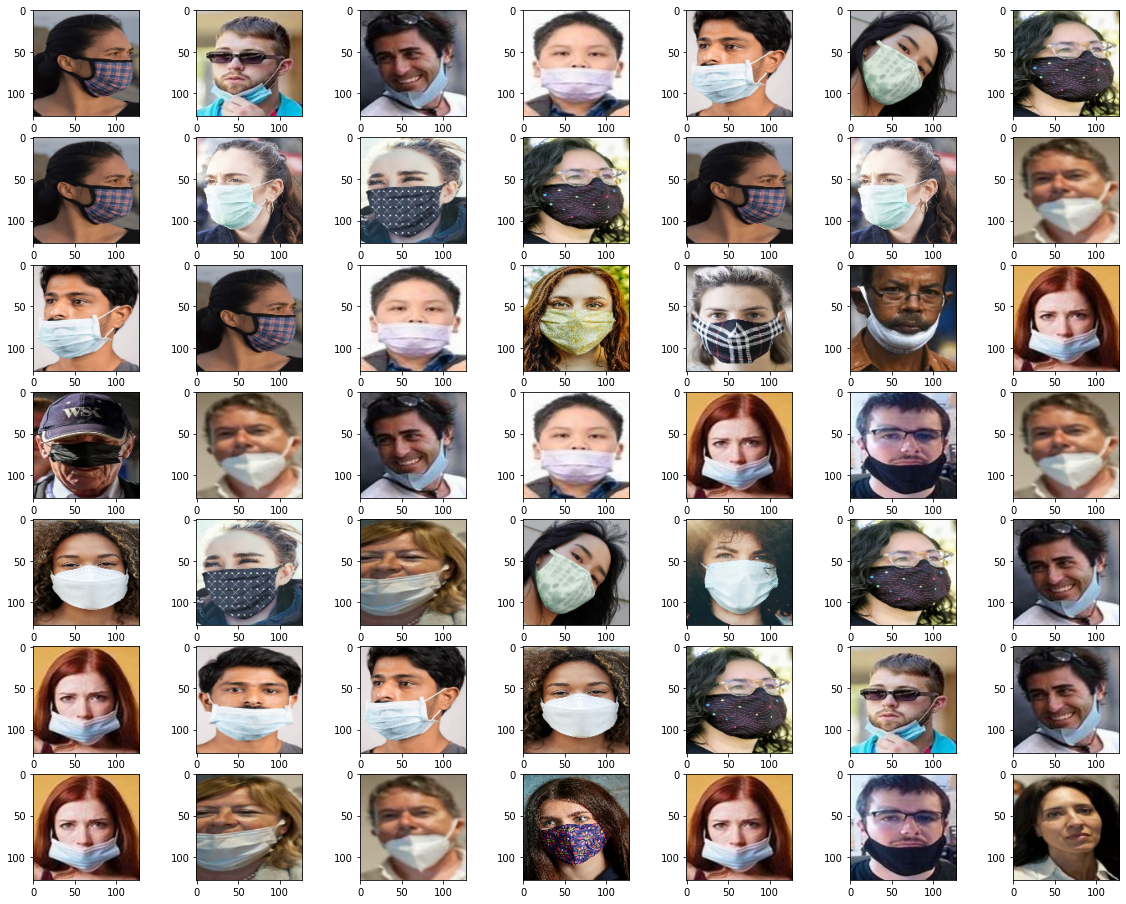

In [40]:
row = int(np.sqrt(len(failed_images)))
col = int(len(failed_images)/row)
fig, ax = plt.subplots(row,col,figsize=(20,16))
count = 0
for r in range(row):
    for c in range(col):
        ax[r][c].imshow(failed_images[count],cmap='gray')
        count = count + 1
plt.show()

In [ ]:
# subplot of Confusion Matrix with label showing statistics of each large in the middle
# fig, ax = plt.subplots(1,2,figsize=(10,8))
# x = np.arange(1,11) 
# ax[0][0].plot(x,acc[0])
# ax[0][0].plot(x,acc[1])
# ax[0][0].plot(x,acc[2])
                       

In [ ]:
# split = .2
# for i in range(6):
#     if i == 0:
#         X_train, X_test, Y_train, Y_test = train_test_split(X[i], Y[i], test_size=split)
#     else:
#         X_tr, X_te, Y_tr, Y_te = train_test_split(X[i], Y[i], test_size=split)
#         if i == 4:
#             X_g = X_te
#             Y_g = Y_te
#         if i == 5:
#             X_g = np.concatenate((X_g, X_te))
#             Y_g = np.concatenate((Y_g, Y_te))
#         X_train = np.concatenate((X_train, X_tr))
#         X_test = np.concatenate((X_test, X_te))
#         Y_train = np.concatenate((Y_train, Y_tr))
#         Y_test = np.concatenate((Y_test, Y_te))

# cnn1 = create_model()
# history = cnn1.fit(X_train, Y_train,
#     epochs=NUM_EPOCHS,
#     shuffle=True)
# # Training dataset
# y_pred = cnn1.predict(X_train)
# y_pred = np.argmax(y_pred, axis=-1)
# y_check = np.argmax(Y_train, axis=-1)
# print(f'Training Accuracy= {sum(y_pred==y_check)/len(y_pred)*100:.3f}')
# # Testing dataset
# y_pred = cnn1.predict(X_test)
# y_pred = np.argmax(y_pred, axis=-1)
# y_check = np.argmax(Y_test, axis=-1)
# print(f'Testing Accuracy= {sum(y_pred==y_check)/len(y_pred)*100:.3f}')

In [ ]:
# # Add test for the google database, determine failures, and plot
# X_google = X[4]
# X_google = np.concatenate((X_google, X[5]))
# Y_google = Y[4]
# Y_google = np.concatenate((Y_google, Y[5]))

# # y_pred = cnn1.predict(X_google)
# y_pred = cnn1.predict(X_g)
# y_pred = np.argmax(y_pred, axis=-1)
# # y_check = np.argmax(Y_google, axis=-1)
# y_check = np.argmax(Y_g, axis=-1)
# print(f'Testing Accuracy= {sum(y_pred==y_check)/len(y_pred)*100:.3f}')
# failed_test = []
# for i, y in enumerate(y_pred):
#     if y != y_check[i]:
#         failed_test.append(i)

In [ ]:
# row = int(np.sqrt(len(failed_test)))
# col = int(len(failed_test)/row)
# fig, ax = plt.subplots(row,col,figsize=(20,16))
# count = 0
# for r in range(row):
#     for c in range(col):
#         ax[r][c].imshow(X_g[failed_test[count]],cmap='gray')
#         count = count + 1
# plt.show()

In [ ]:
# Add test for rest of synth data


In [ ]:
# fig,ax = plt.subplots(1,2,figsize=(16,9))
# ax[0].plot(history.history['accuracy'])
# ax[0].set_title('model accuracy')

# ax[1].plot(history.history['loss'])
# ax[1].set_title('model loss')

# plt.show()